# INF01017 - Aprendizado de Máquina - INF/UFRGS

## Atividade Prática: Árvores de Decisão

As árvores de decisão são conhecidas por possuírem um baixo viés, ao mesmo tempo em que apresentam alta variância.
Isto é, o método é capaz de modelar fronteiras de decisão bastante complexas, o que, por um lado, é positivo, mas torna o algoritmo bastante suscetível a ruído ou a padrões nos dados de treino que não generalizam para instâncias de teste.
Por isso, técnicas de poda são fundamentais para o uso efetivo do modelo em dados novos.

Nessa atividade, iremos analisar como a estrutura e as predições da árvore de decisão são afetadas por pequenas variações no conjunto de treino. Além disso, veremos duas técnicas de poda que podem ser usadas para controlar a complexidade do modelo.

**Este *colab* deve ser usado como base para o preenchimento do questionário encontrado no Moodle. Faça uma cópia do mesmo para realizar o exercício.** A forma mais fácil para duplicar este *colab* é ir em File > "Save a Copy in Drive". Não é necessário entregar este *colab* preenchido, mas guarde-o para caso ache que algum questionário está errado.


### Objetivos da Atividade
* Analisar os impactos da característica de **variância** nas árvores de decisão.
* Analisar o efeito da **poda** em árvores de decisão.
* Observar um exemplo para treinamento e avaliação de modelo


## Carregamento dos Dados

Além de possuir uma grande quantidade de algoritmos de aprendizado de máquina, a biblioteca [scikit-learn](https://scikit-learn.org/stable/index.html) possui também funções para carregar alguns conjuntos de dados.

Nessa seção, vamos usar essas funções para carregar o dataset [Breast Cancer Winconsin](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset). Esse dataset possui um total de 30 atributos relativos a características de tumores de mama e um atributo alvo binário, que indica se o tumor é maligno ou benigno. Todos os 30 atributos são valores reais.

### Obtenção e análise dos dados
O código abaixo carrega o dataset utilizando as funções do scikit-learn e mostra algumas informações básicas sobre os dados

In [5]:
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

data = load_breast_cancer()
X = data.data  # matriz contendo os atributos
y = data.target  # vetor contendo a classe (0 para maligno e 1 para benigno) de cada instância
feature_names = data.feature_names  # nome de cada atributo
target_names = data.target_names  # nome de cada classe

print(f"Dimensões de X: {X.shape}\n")
print(f"Dimensões de y: {y.shape}\n")
print(f"Nomes dos atributos: {feature_names}\n")
print(f"Nomes das classes: {target_names}")

Dimensões de X: (569, 30)

Dimensões de y: (569,)

Nomes dos atributos: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']

Nomes das classes: ['malignant' 'benign']


Como pode ser visto, o dataset possui 569 exemplos, sendo cada exemplo constituído por 30 diferentes atributos.

### Quantidade de Exemplos de cada Classe
É possível também contar quantos exemplos pertencem à classe dos tumores malignos e quantos à classe dos benignos

In [6]:
import numpy as np

n_malign = np.sum(y == 0)
n_benign = np.sum(y == 1)

print("Número de exemplos malignos: %d" % n_malign)
print("Número de exemplos benignos: %d" % n_benign)

Número de exemplos malignos: 212
Número de exemplos benignos: 357


## Variância nas Árvores de Decisão


### Analisando a Estrutura das Árvores de Decisão


Como estudado em aula, a árvore de decisão é conhecida por ser um classificador com alta variância. Isso possui consequências na estrutura das árvores treinadas.

O código abaixo treina várias árvores de decisão com diferentes conjuntos de treino obtidos através do método holdout.
Use-o para responder à Questão 1 do questionário.


In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split  # função do scikit-learn que implementa um holdout


def get_root_node(dt, feature_names):
    feature_idx = dt.tree_.feature[0]
    return feature_names[feature_idx]


n_repeats = 20
root_nodes = []

# variando o seed do holdout, geramos conjuntos de treino e teste um pouco diferentes a cada iteração
for split_random_state in range(0, n_repeats):
  # Holdout com 20% de dados de teste
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=split_random_state)

  # Treinamento da árvore usando os dados de treino
  dt = DecisionTreeClassifier(random_state=0)
  dt.fit(X_train, y_train)

  # Obtemos o atributo usado na raiz e o salvamos na lista
  root_node = get_root_node(dt, feature_names)
  root_nodes.append(root_node)

root_nodes

[np.str_('worst concave points'),
 np.str_('worst perimeter'),
 np.str_('worst perimeter'),
 np.str_('worst concave points'),
 np.str_('worst perimeter'),
 np.str_('worst concave points'),
 np.str_('worst concave points'),
 np.str_('worst area'),
 np.str_('worst perimeter'),
 np.str_('worst radius'),
 np.str_('worst perimeter'),
 np.str_('worst perimeter'),
 np.str_('worst radius'),
 np.str_('worst radius'),
 np.str_('worst radius'),
 np.str_('worst area'),
 np.str_('worst perimeter'),
 np.str_('worst concave points'),
 np.str_('worst concave points'),
 np.str_('mean concave points')]

### Analisando a Acurácia das Árvores de Decisão

A propriedade de variância também implica em efeitos na variabilidade da performance dos modelos.
Podemos usar a acurácia como medida de performance, o que pode ser feito também através do scikit-learn. Posteriormente estudaremos outras métricas de desempenho que são mais indicadas para problemas em que o número de instâncias por classe é desbalanceado, como é o caso deste conjunto de dados.

In [81]:
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia nos dados de teste: %.3f" % accuracy)


Acurácia nos dados de teste: 0.921


O código abaixo executa repetidas vezes o treinamento das árvores de decisão, da mesma forma que no item *Analisando a Estrutura das Árvores de Decisão*.
Modifique-o seguindo as orientações dadas de forma a obter a acurácia para cada execução. Então, calcule a média, desvio padrão, máximo e mínimo dos valores de acurácia obtidos. Use esses resultados para responder à Questão 2.

**Atenção: Não mude os valores que estão sendo passados para os parâmetros random_state para garantir a reprodutibilidade do código**.


In [82]:
n_repeats = 20
accuracies = []

# variando o seed do holdout, geramos conjuntos de treino e teste um pouco diferentes a cada iteração
for split_random_state in range(0, n_repeats):
  # Holdout com 20% de dados de teste
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=split_random_state)

  # Nova instância da árvore de decisão
  dt = DecisionTreeClassifier(random_state=0)

  # Treinamento da árvore usando os dados de treino
  dt.fit(X_train, y_train)

  # Calcule a acurácia nos dados de teste, montando uma lista com os valores calculados
  y_pred = dt.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  accuracies.append(accuracy)

# Calcule a média, desvio padrão, máximo e mínimo das acurácias (pode usar numpy)
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
max_accuracy = np.max(accuracies)
min_accuracy = np.min(accuracies)

print(f"Acurácia média: {mean_accuracy:.3f}")
print(f"Desvio padrão: {std_accuracy:.3f}")
print(f"Acurácia máxima: {max_accuracy:.3f}")
print(f"Acurácia mínima: {min_accuracy:.3f}")


Acurácia média: 0.929
Desvio padrão: 0.024
Acurácia máxima: 0.956
Acurácia mínima: 0.877


### Analisando a Classificação para Instâncias Individuais

1. Treine novamente uma árvore de decisão usando um novo conjunto de treino gerado com a função train_test_split. Utilize 20% de dados de teste e, desta vez, não **especifique valor nenhum para o random_state**.

2. Faça a predição para as instâncias especificadas abaixo ("X_interesting") e preencha na tabela do excel disponibilizada no Moodle a classificação encontrada pelo seu modelo (0 para maligno e 1 para benigno).


In [48]:
X_interesting = X[[40, 86, 297, 135, 73], :]


# 1. Instancie uma nova árvore de decisão, dessa vez sem especificar o valor de random_state
dt = DecisionTreeClassifier()

# 2. Separe o conjunto em treino e teste, dessa vez sem especificar o valor de random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 3. Treine a nova árvore usando o conjunto de treino
dt.fit(X_train, y_train)

# 4. Use a nova árvore treinada para obter predições para os valores de X_interesting acima.
y_pred = dt.predict(X_interesting)

print(y_pred)

[1 0 1 1 0]


## Observando o Efeito da Poda

As árvores de decisão treinadas nos itens anteriores não possuíam nenhuma forma de poda. No entanto, é possível utilizar técnicas de poda através do scikit-learn. Como consequência, elas podem ter uma complexidade além do que é necessário na modelagem do problema.



### Exemplo de Pré-poda: profundidade máxima da árvore
Podemos especificar a profundidade máxima da árvore utilizando o hiperparâmetro max_depth. Veja como exemplo o código abaixo.

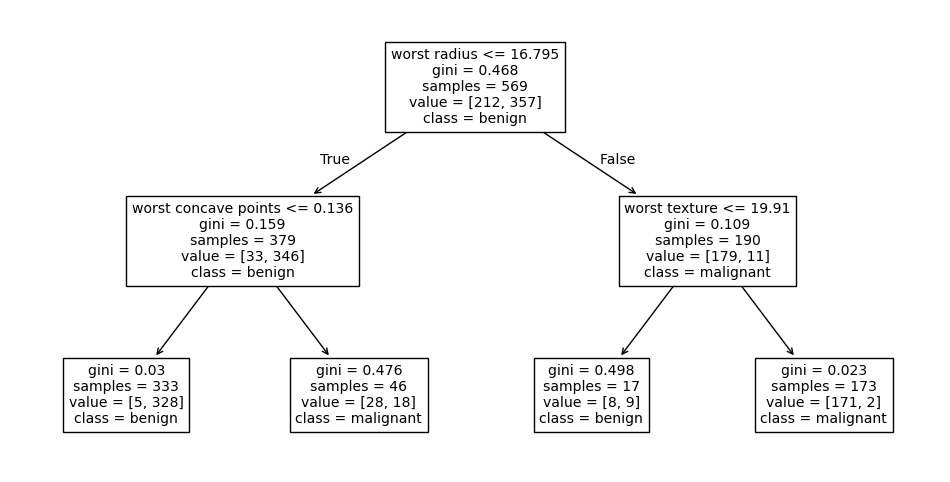

In [13]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X, y)

from sklearn.tree import plot_tree
plt.figure(figsize=(12,6))
_ = plot_tree(dt, feature_names=feature_names, class_names=target_names)

O código abaixo gera árvores de decisão com diferentes profundidades máximas e as avalia em termos de acurácia.

Observe que todas as árvores são treinadas e avaliadas com os mesmos conjuntos de treino, validação e teste, visto que especificamos o parâmetro $random\_state = 42$.

Com base nesse código, e possíveis modificações que você faça a ele, responda à Questão  4 do questionário.

**Não mude o valor que está sendo passado em random_state**.


In [17]:
## Definindo as proporções de treino, validação e teste.
train_ratio = 0.70
test_ratio = 0.15
validation_ratio = 0.15

## Fazendo a primeira divisão, para separar um conjunto de teste dos demais.
## Assuma X_temp e y_temp para os dados de treinamento+validação e X_test e y_test para os de teste
## Dica: configure o random_state para facilitar reprodutibilidade dos experimentos

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_ratio,random_state=42,stratify=y)

## Fazendo a segunda divisão, para gerar o conjunto de treino e validação a partir
## do conjunto de 'treinamento' da divisão anterior
## Assuma X_train e y_train para os dados de treinamento e X_valid e y_valid para os de teste
## Dica: configure o random_state para facilitar reprodutibilidade dos experimentos

X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=validation_ratio/(train_ratio+test_ratio),random_state=42,stratify=y_temp)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(397, 30)
(86, 30)
(86, 30)


In [18]:
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, None]  # None faz com que essa poda não seja aplicada
accuracies_valid = []
accuracies_train = []
for depth in max_depths:
  dt = DecisionTreeClassifier(max_depth=depth, random_state=0)
  dt.fit(X_train, y_train)

  y_pred = dt.predict(X_valid)
  acc = accuracy_score(y_valid, y_pred)
  accuracies_valid.append(acc)
  accuracies_train.append(dt.score(X_train, y_train)) ##para analisar overfitting

In [ ]:
accuracies_valid

[0.9418604651162791,
 0.9651162790697675,
 0.9883720930232558,
 0.9767441860465116,
 0.9767441860465116,
 0.9651162790697675,
 0.9534883720930233,
 0.9534883720930233,
 0.9534883720930233,
 0.9534883720930233,
 0.9534883720930233,
 0.9534883720930233,
 0.9534883720930233]

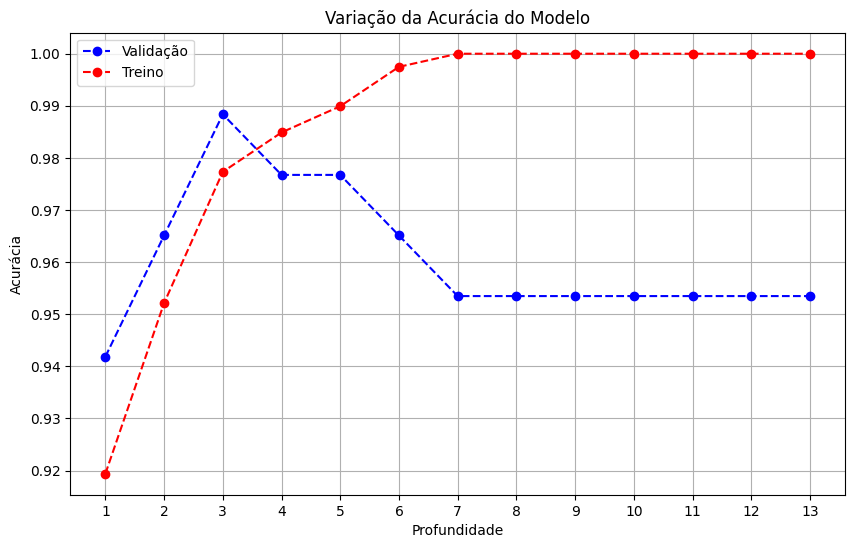

In [19]:
# Plotar a variação das acurácias
plt.figure(figsize=(10,6))
plt.plot(range(1, len(max_depths)+1),  accuracies_valid, marker='o', linestyle='--', color='b', label='Validação')
plt.plot(range(1, len(max_depths)+1), accuracies_train, marker='o', linestyle='--', color='r', label='Treino')
plt.title('Variação da Acurácia do Modelo')
plt.xlabel('Profundidade')
plt.ylabel('Acurácia')
plt.xticks(range(1, len(max_depths)+1))
plt.legend()
plt.grid(True)
plt.show()

Para avaliarmos o desempenho do modelo otimizado em novos dados, devemos repetir o treinamento selecionando o melhor valor de hiperparâmetro(s) com base no gráfico anterior, e fazer a avaliação nos dados de teste.
Para melhorar a capacidade de estimar o desempenho do modelo, podemos treinar com os dados de treinamento e validação, tendo em vista que ambos são independentes do conjunto de teste (dados nunca vistos).


In [20]:
best_max_depth = 3 ## preencha aqui com o melhor valor do hiperparâmetros, conforme análise anterior

In [21]:
# concatena dados de treino e validação, para treinar modelo a ser avaliado com dados de teste
X_train2 = np.concatenate((X_train, X_valid), axis=0)
y_train2 = np.concatenate((y_train, y_valid), axis=0)

In [22]:
# treina e avalia a árvore de decisão com valor otimizado de max_depth
dt = DecisionTreeClassifier(max_depth=best_max_depth, random_state=0)
dt.fit(X_train2, y_train2)

y_pred = dt.predict(X_test)
acc = accuracy_score(y_test, y_pred)
acc

0.9418604651162791

### Exemplo de Pós-poda: Custo-complexidade

A biblioteca scikit-learn possui uma implementação de pós-poda por custo-complexidade, baseada no parâmetro de custo-complexidade $\alpha \ge 0$.

Na implementação descrita na biblioteca, é definido também um custo-complexidade efetivo do nodo. Quanto maior for a taxa de erros ao se podar a subárvore de um nodo, maior será seu custo-complexidade efetivo. Além disso, quanto maior for a complexidade (número de nodos terminais) da subárvore do nodo, menor será seu custo-complexidade efetivo.
Em resumo, um nodo com alto custo-complexidade efetivo é um nodo importante para diminuir a taxa de erros e com baixa complexidade.

Dentro da biblioteca, passamos um hiperparâmetro $ccp\_alpha$ que serve como um custo-complexidade efetivo de corte: subárvores são podadas enquanto houver nodos com custo-complexidade menor do que o hiperparâmetro $ccp\_alpha$.
Ou seja, quando maior for o valor do hiperparâmetro, mais intensa será a poda.

Para mais informações:
* https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning
* https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

Use o código abaixo para resolver à Questão 5.

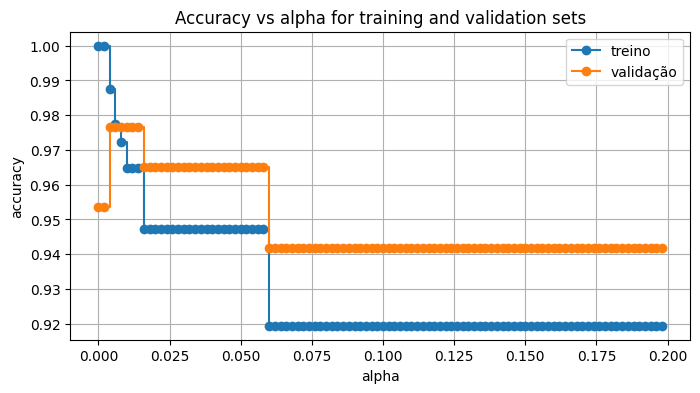

In [23]:
def plot_acc_vs_ccp(accuracies_train, accuracies_valid, ccps):
  fig, ax = plt.subplots(figsize=(8, 4))
  ax.set_xlabel("alpha")
  ax.set_ylabel("accuracy")
  ax.set_title("Accuracy vs alpha for training and validation sets")
  ax.plot(ccps, accuracies_train, marker="o", label="treino", drawstyle="steps-post")
  ax.plot(ccps, accuracies_valid, marker="o", label="validação", drawstyle="steps-post")
  ax.legend()
  ax.grid()
  plt.show()


accs_train = []
accs_valid = []
ccps = [k * 0.001 for k in range(0, 200, 2)]


for ccp in ccps:
  dt = DecisionTreeClassifier(ccp_alpha=ccp, random_state=0)
  dt.fit(X_train, y_train)

  y_pred_train = dt.predict(X_train)
  acc_train = accuracy_score(y_train, y_pred_train)

  y_pred_valid = dt.predict(X_valid)
  acc_valid = accuracy_score(y_valid, y_pred_valid)

  accs_train.append(acc_train)
  accs_valid.append(acc_valid)

plot_acc_vs_ccp(accs_train, accs_valid, ccps)

In [49]:
##valores de ccp
ccps

[0.0,
 0.002,
 0.004,
 0.006,
 0.008,
 0.01,
 0.012,
 0.014,
 0.016,
 0.018000000000000002,
 0.02,
 0.022,
 0.024,
 0.026000000000000002,
 0.028,
 0.03,
 0.032,
 0.034,
 0.036000000000000004,
 0.038,
 0.04,
 0.042,
 0.044,
 0.046,
 0.048,
 0.05,
 0.052000000000000005,
 0.054,
 0.056,
 0.058,
 0.06,
 0.062,
 0.064,
 0.066,
 0.068,
 0.07,
 0.07200000000000001,
 0.074,
 0.076,
 0.078,
 0.08,
 0.082,
 0.084,
 0.08600000000000001,
 0.088,
 0.09,
 0.092,
 0.094,
 0.096,
 0.098,
 0.1,
 0.10200000000000001,
 0.10400000000000001,
 0.106,
 0.108,
 0.11,
 0.112,
 0.114,
 0.116,
 0.11800000000000001,
 0.12,
 0.122,
 0.124,
 0.126,
 0.128,
 0.13,
 0.132,
 0.134,
 0.136,
 0.138,
 0.14,
 0.14200000000000002,
 0.14400000000000002,
 0.146,
 0.148,
 0.15,
 0.152,
 0.154,
 0.156,
 0.158,
 0.16,
 0.162,
 0.164,
 0.166,
 0.168,
 0.17,
 0.17200000000000001,
 0.17400000000000002,
 0.176,
 0.178,
 0.18,
 0.182,
 0.184,
 0.186,
 0.188,
 0.19,
 0.192,
 0.194,
 0.196,
 0.198]

In [50]:
accs_valid

[0.9534883720930233,
 0.9534883720930233,
 0.9767441860465116,
 0.9767441860465116,
 0.9767441860465116,
 0.9767441860465116,
 0.9767441860465116,
 0.9767441860465116,
 0.9651162790697675,
 0.9651162790697675,
 0.9651162790697675,
 0.9651162790697675,
 0.9651162790697675,
 0.9651162790697675,
 0.9651162790697675,
 0.9651162790697675,
 0.9651162790697675,
 0.9651162790697675,
 0.9651162790697675,
 0.9651162790697675,
 0.9651162790697675,
 0.9651162790697675,
 0.9651162790697675,
 0.9651162790697675,
 0.9651162790697675,
 0.9651162790697675,
 0.9651162790697675,
 0.9651162790697675,
 0.9651162790697675,
 0.9651162790697675,
 0.9418604651162791,
 0.9418604651162791,
 0.9418604651162791,
 0.9418604651162791,
 0.9418604651162791,
 0.9418604651162791,
 0.9418604651162791,
 0.9418604651162791,
 0.9418604651162791,
 0.9418604651162791,
 0.9418604651162791,
 0.9418604651162791,
 0.9418604651162791,
 0.9418604651162791,
 0.9418604651162791,
 0.9418604651162791,
 0.9418604651162791,
 0.9418604651

In [ ]:
# treina e avalia a árvore de decisão com valor otimizado de ccp_alpha
best_ccp = 0.004 ## preencha aqui com o melhor valor do hiperparâmetro, conforme análise anterior

dt = DecisionTreeClassifier(ccp_alpha=best_ccp, random_state=0)
dt.fit(X_train2, y_train2)

y_pred = dt.predict(X_test)
acc = accuracy_score(y_test, y_pred)

acc

Atenção: o valor de acurácia com o conjunto de teste não está entre os valores obtidos com o conjunto de validação. Isso pode indicar overfitting no conjunto de validação ou que o conjunto de teste é muito diferente do conjunto de validação.


0.9736842105263158